In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Part 1

# Forward Simulation

In [3]:
def sim(n=2, T=1000, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0=1, lamb1=5):
    #Defining the three possible values of C
    ck = np.arange(3)   
    
    #Gamma matrix for assigning P(C_t | C_{t-1})
    Gamma = np.array([[1-gamma, 0, gamma], 
                      [0, 1-gamma, gamma], 
                      [beta/2, beta/2, 1-beta]])
    
    #Creating random variables with probabilities based of the gamma matrix
    C_transition = [
        stats.rv_discrete(values=(ck,Gamma[0,])),#P(C_t |C_{t-1} = 0)
        stats.rv_discrete(values=(ck,Gamma[1,])),#P(C_t |C_{t-1} = 1)
        stats.rv_discrete(values=(ck,Gamma[2,])),#P(C_t |C_{t-1} = 2)
    ]

    #Creating output vector of C's
    C = np.zeros(T, np.int64)
    #Initializing the C vector
    C[0] = 2

    #Filling up the C-vector with values
    for i in range(T-1):
        C[i+1] = C_transition[C[i]].rvs()
    
    #CPT of Z
    Z_given_C = np.array([1-alpha, alpha, 0.5])  #P(Z = 1| C =c)
    
    #Initializing Z. size=[n,T] specifies we need to create n copies of a series of T simulations
    Z = stats.bernoulli(Z_given_C[C]).rvs(size=[n,T])
    #input:
    '''
    [C_1, C_2, ... C_T]
    '''
    #output: 
    '''[   
        [Z_11, Z_21, Z_31, ... , Z_T1]
        [Z_12, Z_22, Z_32, ... , Z_T2]
        ...
        [Z_1n, Z_2n, Z_3n, ... , Z_Tn]
    ]'''

    #Initialize X   
    X = stats.poisson(np.where(Z, lamb1, lamb0)).rvs()
    #input
    '''[   
        [f(Z_11), f(Z_21), f(Z_31), ... , f(Z_T1)]
        [f(Z_12), f(Z_22), f(Z_32), ... , f(Z_T2)]
        ...
        [f(Z_1n), f(Z_2n), f(Z_3n), ... , f(Z_Tn)]
        ]    
        where
        f(z) = lamb0+(lamb1-lamb0)*z
    '''

    #output
    '''[   
        [X_11, X_21, X_31, ... , X_T1]
        [X_12, X_22, X_32, ... , X_T2]
        ...
        [X_1n, X_2n, X_3n, ... , X_Tn]
    ]'''

    return C,Z,X


C, Z, X = sim(n = 2,T=10)

# Visualizing

# Logistic regression

Packages:

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [4]:
N = 100

n2 = 10
T = 100

#Training set
np.random.seed(42)
C, Z, X = np.empty(shape=(N,T)), np.empty(shape=(N,n2,T)), np.empty(shape=(N, n2,T))
for i in range(N):
    C[i], Z[i], X[i] = sim(n2,T)

#Benchmark set
np.random.seed(80)
N_test = 100
C_test, Z_test, X_test = np.empty(shape=(N_test,T)), np.empty(shape=(N_test,n2,T)), np.empty(shape=(N_test, n2, T))
for i in range(N_test):
    C_test[i], Z_test[i], X_test[i] = sim(n2,T)

Logistic regression using all the X's to predict $C_{50}$

#### Model 1

In [68]:
#Defining regression models
lr_model1 = LogisticRegression(max_iter=10000)

#Model 1 - using all X's
X_model1 = X[:,:,:].reshape((N, 100*n2))
lr_model1.fit(X_model1, C[:,49])   # [49] is C_50 because of zero-indexing
X_model1_test = X_test[:,:,:].reshape((N_test, 100*n2))

In [69]:
#model1
np.mean(lr_model1.predict(X_model1_test) == C_test[:,49])

0.67

#### Model 2

In [70]:
lr_model2 = LogisticRegression(max_iter=10000)

#Model 2 - using only neighbouring X's
X_model2 = X[:,:,48:51].reshape((N, 3*n2))
lr_model2.fit(X_model2, C[:,49])
X_model2_test = X_test[:,:,48:51].reshape((N_test, 3*n2))


In [71]:
#model 2
np.mean(lr_model2.predict(X_model2_test) == C_test[:,49])

0.8

#### Model 3

In [72]:
lr_model3 = LogisticRegression(max_iter=10000)

#Model 3 - using only descendant X's
X_model3 = X[:,:,49].reshape((N, n2))
lr_model3.fit(X_model3, C[:,49])
X_model3_test = X_test[:,:,49].reshape((N_test, n2))


In [73]:
#model 3
np.mean(lr_model3.predict(X_model3_test) == C_test[:,49])


0.67

#### Model 4

In [74]:
lr_model4 = LogisticRegression(max_iter=5000)

#Model 4 - using only neighbouring X's
X_model4 = X[:,:,0:39].reshape((N, 39*n2))
lr_model4.fit(X_model4, C[:,49])
X_model4_test = X_test[:,:,0:39].reshape((N_test, 39*n2))


In [75]:
#model 4
np.mean(lr_model4.predict(X_model4_test) == C_test[:,49])

0.34

# Learning

Below is a function for computing parameter estimates

In [23]:
def learn_par(C,Z,X, Print = False):
    n = X.shape[0]
    T = X.shape[1]

    # Estimating lambda's
    lambda1 = sum(sum((Z[:,t] * X[:,t] for t in range(T)))) / (sum(sum(Z)))
    lambda0 = sum(sum(((np.ones(shape = n)-Z[:,t]) * X[:,t] for t in range(T)))) / (n*T - sum(sum(Z)))

    # Indicator functions of C 
    C_0 = [C[t] == 0 for t in range(T)]
    C_1 = [C[t] == 1 for t in range(T)]
    C_2 = [C[t] == 2 for t in range(T)]

    # Estimating alpha_hat
    if (sum(C_1) > 0):
        sum1 = sum(sum(Z[i,t] * C_1[t] for i in range(n)) for t in range(T)) / (2 * sum(C_1) * n)
    else:
        sum1 = 0
    if (sum(C_0) > 0):
        sum2 = sum(sum((1-Z[i,t]) * C_0[t] for i in range(n)) for t in range(T)) / (2 * sum(C_0) * n)
    else:
        sum2 = 0
    alpha_hat = sum1 + sum2

    # Estimating beta hat
    beta_hat = sum((C_0[t+1] + C_1[t+1])*C_2[t] for t in range(T-1)) / (sum(C_2[0:T-1]))

    # Estimating gamma hat
    gamma_hat = sum((C_2[t+1])*(C_1[t]+C_0[t]) for t in range(T-1)) / (sum(C_1[0:T-1]+ C_0[0:T-1]))

    if (Print == True):
        print("lambda0_hat is: ", lambda0, "\nlambda1_hat is: ", lambda1, "\nalpha_hat is:", alpha_hat, "\nbeta_hat is: ", beta_hat, "\ngamme_hat is: ", gamma_hat)
    
    return lambda0 ,lambda1, alpha_hat, beta_hat, gamma_hat

Test the implementation using simulated data

In [34]:
n1 = 100
n2 = 100
T = 1000

np.random.seed(42)

C, Z, X = np.empty(shape=(n1, T)), np.empty(shape=(n1, n2, T)), np.empty(shape=(n1, n2, T))

for i in range(n1):
    C[i], Z[i], X[i] = sim(n2,T)

In [35]:
learn_par(C[0],Z[0],X[0])

(1.002481825998593,
 5.006103055623822,
 0.9023319433093098,
 0.20175438596491227,
 0.1050228310502283)

In [36]:
par_estimates = np.empty(shape =(n1,5))

for i in range(n1):
    par_estimates[i,:] = learn_par(C[i,:],Z[i,:,:],X[i,:,:])

In [37]:
names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [1, 5, 0.9, 0.2, 0.1]

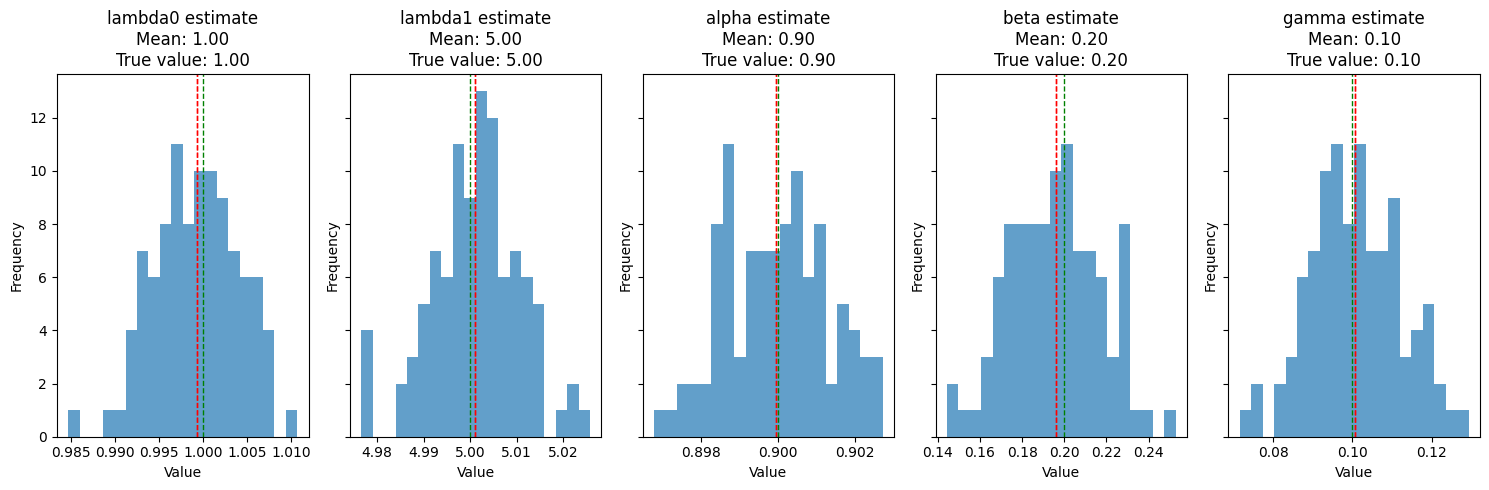

In [38]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates[:,i], bins=20, alpha=0.7)
    
    # Calculate mean
    mean_value = np.mean(par_estimates[:,i])
    
    # Add vertical line for the mean
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

    # Add vertical line for the mean
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

    # Add vertical line for true value
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    
    # Set labels
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Save plot
plt.savefig('histograms_with_means.png')

# Show plot
plt.show()